![example](images/pexels-pixabay-40568.png)

# Phase 3 Project

**Author:** Freddy Abrahamson<br>
**Date created:** 3-27-2022<br>
**Discipline:** Data Science

## Overview
For this project, I will be comparing different models:

* Knn
* Decision Trees
* Random Forest
* XGBoost

I will run these models with different hyperparameters, to see which one can best predict if a person will, or will not take the h1n1 flu vaccine. I will use the F1 score as my metric.

## Business Problem

As a consequence of the Covid 19 pandemic, there is a renewed interest in the vaccination rates for the seasonal flu. A governmental agency is performing an exploratory analysis to identify who is more likely to take the seasonal flu vaccine.

## Data Understanding

The data comes from the National 2009 H1N1 Flu Survey ('H1N1_Flu_Vaccines.csv'). The data is comprised of 36 columns, including the target variable, and 26,707 rows. Each row represents a respondent in the survey. The target variable, 'h1n1_vaccine', is a binary variable which represents whether the respondent took the vaccine or not.

The survey is primarily comprised of binary and multiple choice questions such as:

* 'h1n1_knowledge':&emsp; 0 = No knowledge&emsp;1 = A little knowledge&emsp; 2 = A lot of knowledge
 
*  'health_worker'(binary):&emsp; 0 = no&emsp; 1 = yes


For complete information on the dataset:
https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/

## Import Modules|

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (confusion_matrix, roc_curve, auc, roc_auc_score,f1_score,
                             classification_report, plot_confusion_matrix, precision_recall_curve)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Define Functions

### best_model()

The best_model function returns the best train test score combination based on the auc function, where
the difference between the test and the train scores represents the x axis, and test score represents
the y axis. In order use the auc function, for each x, y coordinate we created a list of length three,
with 0 and 1 at the ends, and the actual x, y values in the middle.

The function takes as arguments(data derived from 'cv_results_' form gridsearch):
1. The type of model used. Will be returned as a string.
2. df1: The dataframe where the 'mean test scores' column, and the column containing the 
   difference between the train and test scores are located.
3. df2: The dataframe with the column containing the model parameters(possibly the same). 

The function returns the following:
1. model type: returned as a string
2. best test score: the test score that corresponds to the best auc score
3. best score difference: the difference between the train and test scores
   that corresponds to the best auc score
4. best train-test combination score(auc): the greatest auc score using the 
   'score difference' as the x values, and the 'test score' as the y values
5. best parameters: the model parameters that correspond to the best auc score
6. best dataframe row: the dataframe row in which the best auc score is found


In [2]:
def best_model(model_type, df1, df2):
    from sklearn.metrics import auc
    """
    The best_model function returns the best train test score combination based on the auc function, where
    the difference between the test and the train scores represents the x axis, and test score represents
    the y axis. In order use the auc function, for each x, y coordinate we created a list of length three,
    with 0 and 1 at the ends, and the actual x, y values in the middle.

    The function takes as arguments(data derived from 'cv_results_' form gridsearch):
    1. The type of model used. Will be returned as a string.
    2. df1: The dataframe where the 'mean test scores' column, and the column containing the 
       difference between the train and test scores are located.
    3. df2: The dataframe with the column containing the model parameters(possibly the same). 

    The function returns the following:
    1. model type: returned as a string
    2. best test score: the test score that corresponds to the best auc score
    3. best score difference: the difference between the train and test scores
       that corresponds to the best auc score
    4. best train-test combination score(auc): the greatest auc score using the 
       'score difference' as the x values, and the 'test score' as the y values
    5. best parameters: the model parameters that correspond to the best auc score
    6. best dataframe row: the dataframe row in which the best auc score is found
    """

#   creating 'test_scores' and 'score_diffs' zero populated lists of shape(rows,3) 
    rows = len(df1)
    test_scores = np.zeros((rows, 3))
    score_diffs = np.zeros((rows, 3))
    auc_scores = []

#   populating 'test_scores' and 'score_diffs' so each list has a format [0,test_score,1],
#   and [0,score_diff,1] respectively
    for row in range(rows):
        test_scores[row][1] = df1['mean_test_score'][row]
        test_scores[row][2] = 1
        score_diffs[row][1] = df1['score_dif'][row]
        score_diffs[row][2] = 1

#   creating a list of all the auc scores
    for row in range(rows):
        auc_score = auc(score_diffs[row], test_scores[row])
        auc_scores.append(auc_score)
        
#   getting the greatest auc score, and the index number of that row    
    best_auc_score = max(auc_scores)
    best_score_index = auc_scores.index(best_auc_score)
    

#   specifying what will be returned
    return (str(model_type), df1['mean_test_score'][best_score_index], df1['score_dif'][best_score_index],
            best_auc_score,df2['params'][best_score_index],best_score_index)


### create_model_scores_df()


The function takes as arguments:
1. A GridSearchCV object.
 
The function returns the following:
1. A dataframe created from 'gridsearch_object'.cv_results_
2. A dataframe with all the mean test and mean train scores, as well as the difference between the respective scores.

In [3]:
def create_model_scores_df(gs_obj):
    """
    The function takes as arguments:
    1. A GridSearchCV object.
 
    The function returns the following:
    1. A dataframe created from 'gridsearch_object'.cv_results_
    2. A dataframe with all the mean test and mean train scores, as well as the difference between 
       the respective scores.
    """
    
    # Creates a dataframe from gs_obj.cv_results_ dictionary:
    results_df = pd.DataFrame(gs_obj.cv_results_)

    # adding new column:
    results_df['score_dif'] = abs(results_df['mean_train_score'] - results_df['mean_test_score'])

    # creates new dataframe with only 'train','test' scores, and their difference:
    score_df = pd.DataFrame()
    score_df = results_df.loc[:,['mean_train_score','mean_test_score','score_dif']]
    
    # returns .cv_results df, and df with mean train/test scores and their difference:
    return results_df, score_df

### print_scores()


The function takes as arguments:
1. A GridSearchCV object.
 
The function returns the following:
1. Prints the mean of the 'mean_train_score' column that is returned by 'GridSearchCV'.cv_results_ . 
2. Prints the mean of the 'mean_test_score' column that is returned by 'GridSearchCV'.cv_results_ . 

In [4]:
def print_scores(gs_obj):
    """
    The function takes as arguments:
    1. A GridSearchCV object.
 
    The function returns the following:
    1. Prints the mean of the 'mean_train_score' column that is returned by 'GridSearchCV'.cv_results_ . 
    2. Prints the mean of the 'mean_test_score' column that is returned by 'GridSearchCV'.cv_results_ . 
    """
    
    # Mean training score
    gs_training_score = np.mean(gs_obj.cv_results_['mean_train_score'])
    
    # Mean test score
    gs_testing_score = np.mean(gs_obj.cv_results_['mean_test_score'])
    
    print(f"Mean Training Score: {gs_training_score :.2%}")
    print(f"Mean Test Score: {gs_testing_score :.2%}")

### to_question_importance_df()

The function takes as arguments:
1. A dataframe that has the original questions(before any type of categorical encoding)as its features.
2. A dataframe that has two columns:

    1. All of the feature names, of the original questions after they have been categorically encoded.
    2. The corresponding feature importance value, for the categorically encoded feature.
   
   The dataframe must have the feature names as its column 0, and the feature importance value as its column 1. 
   
3. Set a minimum value for which a question must have reduced the 'gini' index by, in order to appear in the
       dataframe. 
       
The function returns the following:
1. A dataframe with all the questions that have reduced the 'gini' index by the specified value, and the feature
   importance of each question (sorted descending).


In [408]:
def to_question_importance_df(orig_Q_df, encoded_Q_df, minimum):
    """
    The function takes as arguments:
    1. A dataframe that has the original questions(before any type of categorical encoding)as its features.
    2. A dataframe that has two columns:

        a. All of the feature names, of the original questions after they have been categorically encoded.
        b. The corresponding feature importance value, for the categorically encoded feature.
        
    The dataframe must have the feature names as its column 0, and the feature importance value as its column 1. 
    
    3. Set a minimum value for which a question must have reduced the 'gini' index by, in order to appear in the
       dataframe.
       
       
    The function returns the following:
    1. A dataframe with all the questions that have reduced the 'gini' index by the specified value, and the feature
       importance of each question (sorted descending).

    """
    
    
    # Creating a list with the names of all the original features (questions):
    X_cols = orig_Q_df.columns

    # Creating a dictionary with the keys equal to the original features, and all the values equal to zero:
    q_importance_dict = dict.fromkeys(X_cols, 0)

    
    # The loop will iterate through the whole ftr_importance_df['ftr_name'] column, with each column name in 
    #'X_cols'. Each time the column name in 'X_cols' is a substring of the 'ftr_name', the corresponding
    #'ftr_importance' value will be added to the 'q_importance_dict' value, whose key matches that 'X_cols' 
    # column name: 
    
    
    for col in X_cols:
        for i in range(len(encoded_Q_df)):
            question = encoded_Q_df.iloc[i,0]
            question_importance = encoded_Q_df.iloc[i,1]
            if col in question:
                q_importance_dict[col] += question_importance
                
                
    # Creating a dictionary to use to convert into a dataframe:
    ftr_dict = {'Question':q_importance_dict.keys(), 'Question Importance':q_importance_dict.values()}

    # Creating the dataframe (sort descending):
    questions_df = pd.DataFrame.from_dict(ftr_dict)
    questions_df = questions_df.sort_values(by='Question Importance',ascending=False)
    
    # Create a dataframe that only includes questions that reduces the gini index by a specified minimum amount:
    questions_df_II = questions_df.loc[groups_df['Question Importance']>=minimum]

    # Resetting the Index:
    questions_df_II = questions_df_II.reset_index(drop=True)

    # The following value represents how much of the 'gini' index is reduced by this subset of questions:
    print("The 'gini' index is reduced by: ", questions_df_II['Question Importance'].sum())
    
    # Sort descending based on 'Question Importance':
    questions_df_II = questions_df_II.sort_values(by='Question Importance', ascending=False)
    
    return questions_df_II

# Importing Dataset

In [5]:
#importing dataset
df = pd.read_csv('H1N1_Flu_Vaccines.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [220]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [8]:
print("Raw Counts")
print(df["h1n1_vaccine"].value_counts())
print()
print("Percentages")
print(df["h1n1_vaccine"].value_counts(normalize=True))

Raw Counts
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

Percentages
0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64


A naive model which simply chooses the majority class, would have an accuracy of over 78%.<br>
Since I am using the F1 score as a metric, the naive strategy would be to predict the minority class<br>
in all cases. In this case the recall =1, precision = .21, and the F1 score = .35.<br>
https://machinelearningmastery.com/naive-classifiers-imbalanced-classification-metrics/

# Preprocessing the Data:

In this section I will:<br>
    1. Drop columns if necessary, perform train-test split, and deal with missing values.<br>
    2. Pre-process the training data. Deal with ordinal, and categorical features. Apply smote.<br>
    3. Pre-process the test data. Deal with ordinal, and categorical features.

### Dropping Features, Train-test-split, and Dealing with Missing Values: 

I will drop:
   1. The 'respondent_id'column, since it is a unique identifier.
   2. The 'employment_industry', 'employment_occupation', and 'health_insurance'columns, since about 50% or more of         the values are missing.

In [9]:
# Dropping columns:
df_II = df.drop(['respondent_id','employment_industry','employment_occupation','health_insurance'], axis=1)

In [10]:
# Split df into X and y
X = df_II.drop("h1n1_vaccine", axis=1)
y = df_II["h1n1_vaccine"]

# Perform train-test split with random_state=42 and stratify=y
# stratify y to maintain uniform ratios of the target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [11]:
#impute values based on most common value in each column:
X_train = X_train.apply(lambda x:x.fillna(x.value_counts().index[0]))
X_test = X_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 11075 to 5212
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 20030 non-null  float64
 1   h1n1_knowledge               20030 non-null  float64
 2   behavioral_antiviral_meds    20030 non-null  float64
 3   behavioral_avoidance         20030 non-null  float64
 4   behavioral_face_mask         20030 non-null  float64
 5   behavioral_wash_hands        20030 non-null  float64
 6   behavioral_large_gatherings  20030 non-null  float64
 7   behavioral_outside_home      20030 non-null  float64
 8   behavioral_touch_face        20030 non-null  float64
 9   doctor_recc_h1n1             20030 non-null  float64
 10  doctor_recc_seasonal         20030 non-null  float64
 11  chronic_med_condition        20030 non-null  float64
 12  child_under_6_months         20030 non-null  float64
 13  health_worker

In [221]:
pd.set_option('display.max_columns', None)
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,seasonal_vaccine
11075,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,4.0,2.0,4.0,35 - 44 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,2.0,0
7807,3.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,5.0,4.0,2.0,4.0,35 - 44 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,lrircsnp,"MSA, Principle City",1.0,0.0,0
3014,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,5.0,1.0,1.0,65+ Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,atmpeygn,Non-MSA,1.0,0.0,0
1671,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,5.0,4.0,4.0,5.0,4.0,18 - 34 Years,12 Years,White,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,oxchjgsf,Non-MSA,0.0,0.0,0
16691,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,2.0,4.0,5.0,2.0,4.0,65+ Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,fpwskwrf,"MSA, Not Principle City",1.0,0.0,1


<b>There is now, no missing data in the training, and test datasets.</b>

## Pre-processing training data:

In [362]:
# Splitting dataframe between ordinals , nominals, and continuous values.

# Creating a dataframe with columns that have ordinal values:
X_train_ord =  X_train.iloc[:,np.r_[0:2,14:22,24]]

# Creating a dataframe with columns that have continuous values:
X_train_cont = X_train.iloc[:,30:32]

# Creating a list of ordinal, and continuous columns, to be used to create the dataframe with nominal values:
ord_cols = X_train_ord.columns
cont_cols = X_train_cont.columns

# Creating a dataframe with columns that have nominal values:
cols_to_drop = ord_cols.append(cont_cols)
X_train_nom = X_train.drop(cols_to_drop, axis=1)

# Creating lists of index(s) for both the ordinal, and nominal dataframes. For use when recreating these dataframes:
X_train_ord_index = X_train_ord.index
X_train_nom_index = X_train_nom.index

# I will convert all the columns in the dataset to string type, so I can then encode them:
X_train_ord = X_train_ord.astype(str)
X_train_nom = X_train_nom.astype(str)

# creating Encoder objects:
enc = OrdinalEncoder()
ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

# fitting Encoder objects with their respective datasets:
X_train_enc = enc.fit_transform(X_train_ord)
X_train_ohe = ohe.fit_transform(X_train_nom)

# creating an array with enc and ohe column names:
enc_col_names = X_train_ord.columns
ohe_col_names = ohe.get_feature_names(X_train_nom.columns)

# Setting arrays back to dataframes:
X_train_enc_df = pd.DataFrame(X_train_enc, columns=enc_col_names,index=X_train_ord_index)
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_col_names,index=X_train_nom_index)

# Concatenating to put the original dataframe back together:
X_train_II_encoded = pd.concat([X_train_enc_df,X_train_ohe_df,X_train_cont],axis=1)
X_train_II_encoded.head()

# resampling with Smote *after some trial and error, I found .40 to be optimal:
X_train_II_encoded_resampled, y_train_resampled = SMOTE(sampling_strategy=0.40).fit_resample(X_train_II_encoded, y_train)


In [363]:
# After applying SMOTE the minority class(1), is now 40% of the majority class (0): 
print("Raw Counts")
print(y_train_resampled.value_counts())
print()
print("Percentages")
print(y_train_resampled.value_counts(normalize=True))

Raw Counts
0    15775
1     6310
Name: h1n1_vaccine, dtype: int64

Percentages
0    0.714286
1    0.285714
Name: h1n1_vaccine, dtype: float64


## Pre-processing test data:

In [364]:
# Splitting dataframe between ordinals , nominals, and continuous values.

# Creating a dataframe with columns that have ordinal values:
X_test_ord =  X_test.iloc[:,np.r_[0:2,14:22,24]]

# Creating a dataframe with columns that have continuous values:
X_test_cont = X_test.iloc[:,30:32]

# Creating a list of ordinal, and continuous columns, to be used to create the dataframe with nominal values:
ord_cols = X_test_ord.columns
cont_cols = X_test_cont.columns

# Creating a dataframe with columns that have nominal values:
cols_to_drop = ord_cols.append(cont_cols)
X_test_nom = X_test.drop(cols_to_drop, axis=1)

# Creating lists of index(s) for both the ordinal, and nominal dataframes. For use when recreating these dataframes:
X_test_ord_index = X_test_ord.index
X_test_nom_index = X_test_nom.index

# I will convert all the columns in the dataset to string type, so I can then encode them:
X_test_ord = X_test_ord.astype(str)
X_test_nom = X_test_nom.astype(str)

# Setting arrays back to dataframes:
X_test_enc_df = pd.DataFrame(enc.transform(X_test_ord), columns=enc_col_names,index=X_test_ord_index)
X_test_ohe_df = pd.DataFrame(ohe.transform(X_test_nom), columns=ohe_col_names,index=X_test_nom_index)

# Concatenating to put the original dataframe back together:
X_test_II_encoded = pd.concat([X_test_enc_df,X_test_ohe_df,X_test_cont],axis=1)
X_test_II_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6677 entries, 12369 to 24368
Data columns (total 65 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   h1n1_concern                          6677 non-null   float64
 1   h1n1_knowledge                        6677 non-null   float64
 2   opinion_h1n1_vacc_effective           6677 non-null   float64
 3   opinion_h1n1_risk                     6677 non-null   float64
 4   opinion_h1n1_sick_from_vacc           6677 non-null   float64
 5   opinion_seas_vacc_effective           6677 non-null   float64
 6   opinion_seas_risk                     6677 non-null   float64
 7   opinion_seas_sick_from_vacc           6677 non-null   float64
 8   age_group                             6677 non-null   float64
 9   education                             6677 non-null   float64
 10  income_poverty                        6677 non-null   float64
 11  behavioral_a

In [365]:
X_test_II_encoded.head()

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,income_poverty,behavioral_antiviral_meds_0.0,behavioral_antiviral_meds_1.0,behavioral_avoidance_0.0,behavioral_avoidance_1.0,behavioral_face_mask_0.0,behavioral_face_mask_1.0,behavioral_wash_hands_0.0,behavioral_wash_hands_1.0,behavioral_large_gatherings_0.0,behavioral_large_gatherings_1.0,behavioral_outside_home_0.0,behavioral_outside_home_1.0,behavioral_touch_face_0.0,behavioral_touch_face_1.0,doctor_recc_h1n1_0.0,doctor_recc_h1n1_1.0,doctor_recc_seasonal_0.0,doctor_recc_seasonal_1.0,chronic_med_condition_0.0,chronic_med_condition_1.0,child_under_6_months_0.0,child_under_6_months_1.0,health_worker_0.0,health_worker_1.0,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,seasonal_vaccine_0,seasonal_vaccine_1,household_adults,household_children
12369,3.0,1.0,3.0,0.0,3.0,3.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17593,3.0,2.0,4.0,1.0,0.0,4.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0
2698,3.0,1.0,3.0,0.0,1.0,4.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
13754,2.0,2.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7106,2.0,1.0,2.0,3.0,1.0,0.0,3.0,1.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0


# Classification models:

In this section I will create the following models using their default settings, and then with different combinations of settings using GridSearchCV:
    
    1.  K Nearest Neighbors (KNN)
    2.  Decision Tree
    3.  Random Forest
    4.  XGBoost

## K Nearest Neighbors (KNN)

### K Nearest Neighbors Baseline Model:

In [366]:
# Creating K nearest neighbor classifier object 
knn = KNeighborsClassifier(n_jobs = -1)

# Using 2-split cross-validation to score the classification:
knn_cv_score = cross_val_score(knn, X_train_II_encoded_resampled, y_train_resampled, scoring="f1", cv=2)

# Return the mean of the 2 f1 scores:
mean_knn_cv_score = np.mean(knn_cv_score)
print(f"Mean Cross Validation Score: {mean_knn_cv_score :.2%}")

Mean Cross Validation Score: 64.58%


### Using GridSearchCV to create additional KNN models:

In [367]:
# Define the parameter grid:

knn_param_grid = {
    'n_neighbors': [5,12,20],
    'metric'     : ['minkowski'],
    'p'          : [1,2,3,4]
    
}

In [368]:
# Instantiate GridSearchCV object:
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=2, scoring='f1',return_train_score=True, n_jobs = -1)

# Fit to the data:
knn_grid_search.fit(X_train_II_encoded_resampled, y_train_resampled);

In [369]:
print_scores(knn_grid_search)

Mean Training Score: 66.70%
Mean Test Score: 60.10%


In [370]:
# Display model results:
knn_results_df, knn_score_df =  create_model_scores_df(knn_grid_search)
knn_score_df.describe()

,mean_train_score,mean_test_score,score_dif
count,12.000000,12.000000,12.000000
mean,0.667048,0.601019,0.066029
std,0.050812,0.028163,0.026112
min,0.604016,0.563208,0.038646
25%,0.633664,0.578426,0.046755
50%,0.650581,0.595512,0.055777
75%,0.707079,0.624587,0.082492
max,0.761413,0.645760,0.123539


## Decision Trees

### Decision Tree Baseline Model:

In [373]:
# Creating decision tree classifier object
dec_tree = DecisionTreeClassifier(random_state=42)

# Using 2-split cross-validation to score the classification:
dec_tree_cv_score = cross_val_score(dec_tree, X_train_II_encoded_resampled, y_train_resampled, cv=2,scoring='f1')

# Return the mean of the 2 f1 scores:
mean_dec_tree_cv_score = np.mean(dec_tree_cv_score)
print(f"Mean Cross Validation Score: {mean_dec_tree_cv_score :.2%}")

Mean Cross Validation Score: 60.20%


### Using GridSearchCV to create additional Decision Tree models:

In [23]:
# Define the parameter grid:

dec_tree_param_grid = {
    'criterion'        : ['gini', 'entropy'],
    'max_depth'        : [None,5,6, 7, 8],
    'min_samples_split': [2,3,5],
    'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
    'class_weight'     : [None, 'balanced']
}

In [24]:
# Instantiate GridSearchCV object:
dec_tree_grid_search = GridSearchCV(dec_tree, dec_tree_param_grid, cv=2, return_train_score=True, 
                                    scoring='f1', n_jobs = -1)

# Fit to the data:
dec_tree_grid_search.fit(X_train_II_encoded_resampled, y_train_resampled);

In [25]:
print_scores(dec_tree_grid_search)

Mean Training Score: 76.08%
Mean Test Score: 65.15%


In [26]:
# Display model results:
dec_tree_results_df, dec_tree_score_df =  create_model_scores_df(dec_tree_grid_search)
dec_tree_score_df.describe()

,mean_train_score,mean_test_score,score_dif
count,360.000000,360.000000,360.000000
mean,0.760834,0.651462,0.109372
std,0.073325,0.029733,0.094809
min,0.701968,0.584280,0.029462
25%,0.714262,0.629202,0.047320
50%,0.732539,0.650557,0.078091
75%,0.752200,0.681296,0.113855
max,1.000000,0.690299,0.392054


## Random Forests

### Random Forest Baseline Model:

In [27]:
# Creating random forest classifier object:
forest = RandomForestClassifier(n_jobs = -1,random_state=42)

# Using 2-split cross-validation to score the classification:
forest_cv_score = cross_val_score(forest, X_train_II_encoded_resampled, y_train_resampled, cv=2,scoring='f1')

# Return the mean of the 2 f1 scores:
mean_forest_cv_score = np.mean(forest_cv_score)
print(f"Mean Cross Validation Score: {mean_forest_cv_score :.2%}")

Mean Cross Validation Score: 67.73%


### Using GridSearchCV to create additional Random Forests:

In [28]:
# Define the parameter grid:

forest_param_grid = {
              'criterion'        : ['gini', 'entropy'],
              'max_depth'        : [None, 4,5,6,8],
              'min_samples_split': [2,3,4,6],
              'max_features'     : [15, 20, 28, 32, 'auto'],
             'class_weight'      : [None, 'balanced'],
              'n_estimators'     : [100, 150]
         
}

In [29]:
# Instantiate GridSearchCV object:
forest_grid_search = GridSearchCV(forest, forest_param_grid, cv=2, return_train_score=True,
                                  scoring='f1', n_jobs = -1)

# Fit to the data:
forest_grid_search.fit(X_train_II_encoded_resampled, y_train_resampled);

In [30]:
print_scores(forest_grid_search)

Mean Training Score: 78.01%
Mean Test Score: 66.90%


In [31]:
# Display model results:
forest_results_df, forest_score_df =  create_model_scores_df(forest_grid_search)
forest_score_df.describe()

,mean_train_score,mean_test_score,score_dif
count,800.000000,800.000000,800.000000
mean,0.780074,0.669038,0.111037
std,0.109082,0.031645,0.102096
min,0.628180,0.576898,0.022708
25%,0.711912,0.651688,0.043603
50%,0.735937,0.680077,0.070931
75%,0.783166,0.694086,0.109403
max,1.000000,0.707529,0.337069


## XGBoost

### XGBoost Baseline Model:

In [375]:
# Creating XGBoost classifier object:
xgboost_clf = XGBClassifier(random_state=42, n_jobs = -1)

# Using 2-split cross-validation to score the classification:
xgboost_clf_cv_score = cross_val_score(xgboost_clf, X_train_II_encoded_resampled, y_train_resampled,
                                       cv=2, scoring='f1')

# Return the mean of the 2 f1 scores:
mean_xgboost_clf_cv_score = np.mean(xgboost_clf_cv_score)
print(f"Mean Cross Validation Score: {mean_xgboost_clf_cv_score :.2%}")

Mean Cross Validation Score: 62.44%


### Using GridSearchCV to create additional XGBoost Classifiers:

In [376]:
# Define the parameter grid:

xgboost_param_grid = {
    'learning_rate': [None, .08, .1],
    'max_depth': [None, 4, 5, 6 ],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.65, 1],
    'min_split_loss' : [0, .5],
    'n_estimators' : [100, 160],
    'reg_alpha':[None, .5,],
    'scale_pos_weight' : [None, 3.0]
    
}

In [377]:
# Instantiate GridSearchCV object:
xgboost_clf_grid_search = GridSearchCV(xgboost_clf, xgboost_param_grid, cv=2, return_train_score=True,
                                  scoring='f1', n_jobs = -1)

# Fit to the data
xgboost_clf_grid_search.fit(X_train_II_encoded_resampled, y_train_resampled);

In [378]:
print_scores(xgboost_clf_grid_search)

Mean Training Score: 85.52%
Mean Test Score: 65.23%


In [379]:
# Display model results:
xgboost_results_df, xgboost_score_df =  create_model_scores_df(xgboost_clf_grid_search)
xgboost_score_df.describe()

,mean_train_score,mean_test_score,score_dif
count,1152.000000,1152.000000,1152.000000
mean,0.855194,0.652281,0.202913
std,0.055369,0.035101,0.068594
min,0.771782,0.602376,0.074990
25%,0.814565,0.619459,0.150147
50%,0.841542,0.639696,0.197675
75%,0.884308,0.693003,0.253759
max,0.980352,0.700016,0.360439


# Choosing the Best Model:

In [38]:
# Creating a dataframe to compare models

# Creating list of arguments for the 'best_model' function
best_model_args = [['knn', knn_score_df, knn_results_df],
                   ['decsion tree', dec_tree_score_df, dec_tree_results_df],
                   ['random forest', forest_score_df, forest_results_df],
                   ['xgboost', xgboost_score_df, xgboost_results_df]]


# Loop counter representing the 4 sets of arguments for the 'best_model' function:
counter = 0
# This list will hold the stats for each model:
model_stats_list = []
# Column names used to create the dataframe:
model_stats_df_cols = ['model type','best test score(f1)','best score difference',
                      'best train-test combination score(auc)','best parameters',
                      'best dataframe row']

# Loop used to populate 'model_stats_list':
while counter <4:
    args = best_model_args[counter]
    model_stats = best_model(args[0],args[1],args[2])
    model_stats_list.append(model_stats)
    counter+=1

# Creating dataframe from the 'model_stats_list':
model_stats_df = pd.DataFrame(model_stats_list, columns=model_stats_df_cols)
pd.set_option('display.max_colwidth', None)
model_stats_df   

,model type,best test score(f1),best score difference,best train-test combination score(auc),best parameters,best dataframe row
0,knn,0.613334,0.039954,0.786690,"{'metric': 'minkowski', 'n_neighbors': 12, 'p': 2}",5
1,decsion tree,0.684905,0.029462,0.827722,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}",198
2,random forest,0.699000,0.030049,0.834476,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 20, 'min_samples_split': 4, 'n_estimators': 150}",693
3,xgboost,0.699029,0.076051,0.811489,"{'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 3, 'min_split_loss': 0, 'n_estimators': 100, 'reg_alpha': None, 'scale_pos_weight': 3.0, 'subsample': 0.65}",546


The best model, based on the auc metric (0.831498) is random Forest, with an F1 test score of 0.694205.	

# Recreating the  the Best Model:

In this section I will:<br>
    1. Recreate the best model using the test data and create a confusion matrix<br>
    2. Obtain the questions that have the highest aggregate feature importances, and plot them

In [381]:
# Instantiate a RandomForestClassifier object:
best_forest = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 5,
                                      max_features = 32, min_samples_split = 2, n_estimators = 150,
                                      random_state = 42, n_jobs = -1)

# Fit data to the RandomForestClassifier object:
best_forest.fit(X_train_II_encoded_resampled, y_train_resampled)
best_forest_preds = best_forest.predict(X_test_II_encoded)

#Returns the f1 score on the given test data and labels:
score = f1_score(y_test, best_forest_preds)
score

0.6173651054505614

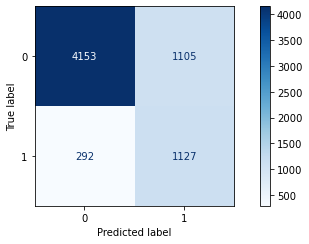

In [382]:
# Visualize the confusion matrix:
plot_confusion_matrix(best_forest, X_test_II_encoded, y_test,
                     cmap=plt.cm.Blues)
plt.show()

## Obtain most important features

In [314]:
# Creating a 'ftr_importance' array:
ftr_importance = np.array(best_forest.feature_importances_)

# Creating a 'ftr_names' array:
ftr_names = np.array(X_train_II_encoded.columns)

# Putting the two arrays together to create a 2d dataframe:
ftr_importance_arr = np.vstack((ftr_names, ftr_importance)).T

# Creating column names list for dataframe:
col_names = ['ftr_name', 'ftr_importance']

# Converting 'ftr_importance_arr' into a dataframe and sorting by feature importance:
ftr_importance_df = pd.DataFrame(ftr_importance_arr, columns=col_names).sort_values(
    by='ftr_importance')

# Dataframe info():
ftr_importance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 56 to 61
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ftr_name        65 non-null     object
 1   ftr_importance  65 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


In [315]:
# Converting the "ftr_importance" values to float:
ftr_importance_df['ftr_importance'] = ftr_importance_df['ftr_importance'].astype(float)
ftr_importance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 56 to 61
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ftr_name        65 non-null     object 
 1   ftr_importance  65 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


After trying out different minimum 'gini' reduction thresholds, I found .005 to give the best balance between the number of questions, and the total 'gini' index reduction. The following returns a datframe with the top questions, based on feature importance, and the feature importance of each question.

In [409]:
questions_df = to_question_importance_df(X_train, ftr_importance_df,.005)
questions_df

The 'gini' index is reduced by:  0.9781231056577477


,Question,Question Importance
0,seasonal_vaccine,0.493765
1,doctor_recc_h1n1,0.258324
2,doctor_recc_seasonal,0.084587
3,opinion_h1n1_vacc_effective,0.076946
4,opinion_h1n1_risk,0.053296
5,health_worker,0.011205


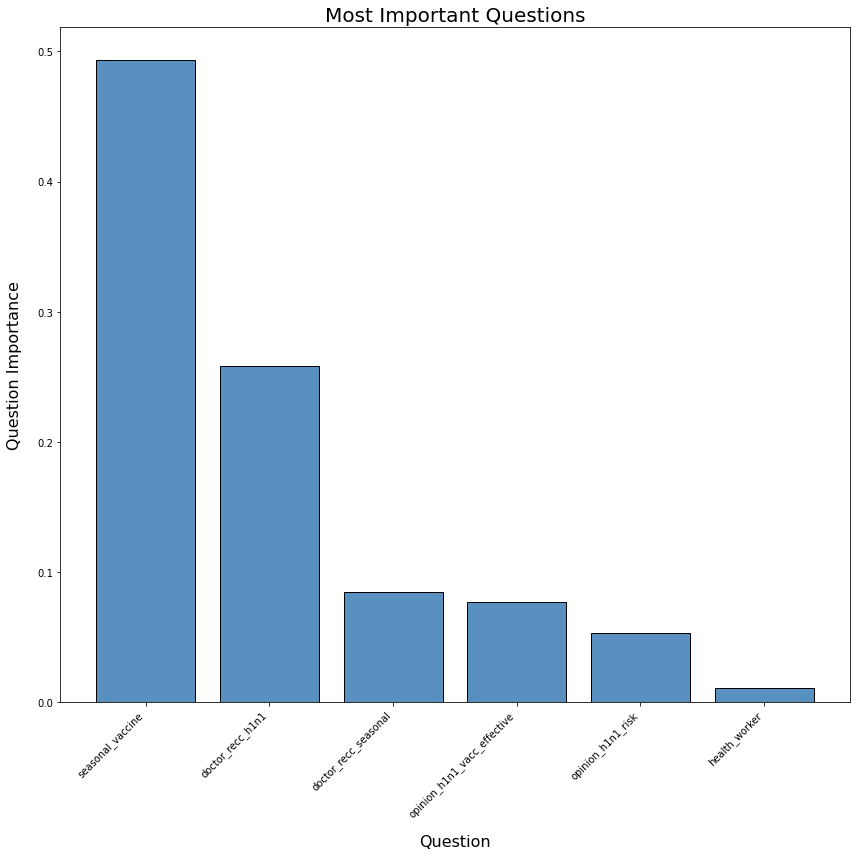

In [407]:
    # Plotting the datafrme values with the six most important questions:
    plt.figure(figsize=(12,12))
    plt.title('Most Important Questions', fontsize=20)
    plt.bar(questions_df_II['Question'], questions_df_II['Question Importance'],color='#5891bf',edgecolor='black')
    plt.xlabel('Question', fontsize=16, labelpad=15)
    plt.ylabel('Question Importance', fontsize=16, labelpad=15)
    plt.xticks(rotation=45, ha="right");

# Recommendations

<b>metric</b>: F1 score

<b>model</b>: Random Forest

<b>model parameters</b>: class_weight = 'balanced', criterion = 'gini', max_depth = 5,<br>
                         max_features = 32, min_samples_split = 2, n_estimators = 150,<br>
                         random_state = 42, n_jobs = -1<br>
                              
<b>how to handle class imbalance</b> &emsp;: Get more questionaires with respondents who are taking the vaccine, in order to balance the data. As it stands now, the ratio of respondents who have not taken the vaccine, to those who have, is almost 4:1. Short of that, using SMOTE(sampling_strategy=0.40) gave the best results. 

<b>Recommend to place a special emphasis on the following questions, since they account for more
almost 97% of total feature importance metric (decrease in the gini impurity score):
* seasonal_vaccine
* doctor_recc_h1n1	
* doctor_recc_seasonal	
* opinion_h1n1_vacc_effective
* opinion_h1n1_risk
* health_worker	
    
I believe that this small reduction in the 'feature importance metric' could be offset by having a considerably shorter questionnaire, with only six questions, thereby having more people successfully completing them.</b>

# Project Conclusion: Main Take-aways

1. This project helped me appreciate that there a few things that should be done prior to working with the models:
       1. Clearly define a question, or goal that would be resolved by the model.
       2. Choose a metric that would best measure the success of your model,as it pertains to your goal.
       3. Try to define a naive strategy, and its success rate, so you have something to compare your model to.


2. My goal in this project was to create a model that would identify, as correctly as possible, who will, and who won't take the h1n1 vaccine. My prediction results could be categorized as any of the following four:    
       1. True positive: The respondent was predicted to have taken the vaccine, and actually took it.
       2. True negative: The respondent was predicted not to have taken the vaccine, and did not take it.
       3. False positive: The respondent was predicted to have taken the vaccine, but did not take it.
       4. False negative: The respondent was predicted to not have taken the vaccine, but actually took it.

Given that my goal is to be as 'accurate' as possible, there is no upside in identifying one class more aggresively than the other. I chose the F1 metric because it does a good job of minimizing false positives, and false negatives on an imbalanced data set. 

3. I used the auc function to determine the best train/test score combination. I set the difference between the train and the test scores as the x axis, and the test score itself as the y axis. Based on this the Random Forest model was the best.

4. I would consdider finding the optimal threshold and seeing if that makes a difference.
  